<a href="https://colab.research.google.com/github/mannodiarun/perovs_dft_ml/blob/main/Neural_Network_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *Using neural networks to predict perovskite bandgaps*

In this tutorial we will learn how to use the [Keras](https://keras.io/) and [Tensorflow](https://www.tensorflow.org/) libraries to create a neural network regression model that estimates perovskite bandgaps.

You can find another example of neural network regression using Keras in the [TensorFlow Tutorials](https://nanohub.org/tools/tftutorials) nanoHUB tool.

This tutorial uses Python, some familiarity with programming would be beneficial but is not required. Run each code cell in order by hitting "Shift + Enter", or clicking the "Run" button in the menu bar above this notebook. Feel free to modify the code to familiarize yourself with how the code works.

**Outline:**

1. Import libraries
2. Getting data
3. Preprocessing and Organizing Data
4. Creating the neural network model
5. Training the model
6. Evaluate model training
7. Make some predictions

**Get started:** Hit "Shift-Enter" on the code cells to run! 

### Step 1. Import libraries

We first import the relevant libraries. These imports are over four cells:

The first cell imports the [Pandas](https://pandas.pydata.org/) and [Numpy](https://numpy.org/) libraries that we will use to import and convert the data to appropriate formats for the neural network. We will also import modules from the [Scikit-Learn](https://scikit-learn.org/stable/) library that will help pre-process the data

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt

The next cell imports the [Keras](https://keras.io/) and [Tensorflow](https://www.tensorflow.org/) libraries, which we use to construct and train the neural network. The third cell sets the random seed to ensure consistent results every time the notebook is run, an important step in reproducibility

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

### Step 2. Getting data

We will download the data from [this](https://github.com/mannodiarun/perovs_dft_ml) Github repository, after which we will use the Pandas `read_csv()` function to read in the data into a Pandas dataframe

In [ ]:
!wget https://raw.githubusercontent.com/mannodiarun/perovs_dft_ml/main/PBE_data.csv

--2022-11-27 15:15:24--  https://raw.githubusercontent.com/mannodiarun/perovs_dft_ml/main/PBE_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242860 (237K) [text/plain]
Saving to: ‘PBE_data.csv’

PBE_data.csv        100%[===================>] 237.17K  --.-KB/s    in 0.008s  

2022-11-27 15:15:24 (28.1 MB/s) - ‘PBE_data.csv’ saved [242860/242860]



In [ ]:
data = pd.read_csv("./PBE_data.csv")

The first element in each row of this dataframe is a chemical composition, indicated by the column "Formula". We need to convert the raw chemical formula into a numerical representation to develop ML models. This process is generally called featurization, and we could use libraries such as [matminer](https://github.com/hackingmaterials/matminer) do to this. In our case, the featurization has already been performed and stored in columns of the CSV file we are using. So we will just load these features into a dataframe.

In [ ]:
#descriptors indicating composition (formula)
Comp_desc = pd.DataFrame(data, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I'])
#descriptors using elemental properties (ionic radii, density etc.)
Elem_desc = pd.DataFrame(data, columns=['A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 
                                        'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 
                                        'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 
                                        'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
#combined descriptors
All_desc = pd.DataFrame(data, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'A_ion_rad', 
                                       'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 
                                       'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 
                                       'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 
                                       'X_at_num', 'X_period'])

X = copy.deepcopy(Comp_desc)

#### Data Visualization

Before training models on our data, we can visualize the kind of data we are working with. This can be done in multiple ways, and in this notebook we are going to look at the range of bandgaps present in our dataset via a histogram.

Visualization here is performed using Matplotlib, a Python plotting library. Other options include [Plotly](https://plotly.com/python/) or [Bokeh](https://bokeh.org/).

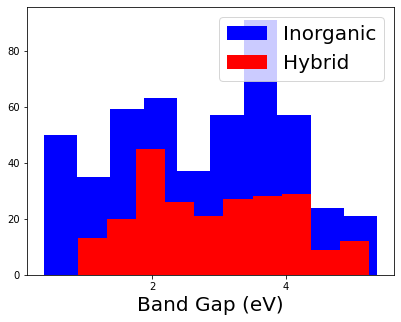

In [ ]:
fig = plt.subplots( figsize=(6,6) )
plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
prop = data.Gap

prop_group1 = data.loc[(data.MA > 0) | (data.FA > 0)].Gap

plt.hist(prop, color='b', label='_nolegend_')
plt.hist(prop_group1, color='r', label='_nolegend_')
plt.hist(prop[0], color='b', label='Inorganic')
plt.hist(prop_group1[0], color='r', label='Hybrid')
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.xlabel('Band Gap (eV)', c='k', fontsize=20)
plt.legend(loc='upper right', ncol=1, frameon=True, prop={'size':20})

### Step 3. Preprocessing and Organizing Data

We could use all the data at hand to train our model. However, this model would have no guarantee of performing well on an unseen dataset. To mitigate this, we could take one extra step and partition out a "testing" dataset from our data. This dataset will not be used in training the model, and will only be used to judge model performance on unseen data. 

We can train a model using a single training set, and evaluate it on the test set. But many ML models such as neural networks come with "hyperparameters" that we do not know the setting for (example: number of layers in a neural network). With one training and testing dataset, we do not have a way to tune the "hyperparameters" of the model. 

There are two solutions to this problem:
1. Carve out an additional "validation" dataset from the training dataset
2. Cross-validation

In approach 1, we define a validation set (from within our training set) that will be used as data to evaluate the hyperparameter settings of our model. However, this reduces the amount of data available for training and can be problematic for small datasets. Cross-validation (approach 2) resolves this by using multiple iterations where each iteration uses one chunk of the training data as a validation set. This allows us to tune hyperparameters without wasting too much data.

You can read more about cross-validation [here](https://scikit-learn.org/stable/modules/cross_validation.html). 

Here, we adopt approach 1, i.e, carving a fixed validation set from the training data. For an example of cross-validation, refer to the Random Forest Regressor approach in notebook 2 of this tutorial series.

We use the Scikit Learn `train_test_split` function to reserve 20% of the data as a test set. You can read more about the `train_test_split` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

now we need to preprocess the data, we will use a simple min-max normalization scheme from scikit learn

In [ ]:
#scale inputs
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, data.Gap, test_size=0.2, random_state=0)

ntrain = Y_train.size
ntest = Y_test.size

X_train_fl = np.array(X_train, dtype="float32")
Y_train_fl = np.array(Y_train, dtype="float32")

X_test_fl = np.array(X_test, dtype="float32")
Y_test_fl = np.array(Y_test, dtype="float32")

We now further divide the non-test dataset into training and validation sets. The first 80% is reserved for training, and the remaining 20% is reserved as a validation set. A validation set helps us control model hyperparameters, and monitor for overfitting.

In [ ]:
#prepare training and validation sets
X = X_train_fl
Y = Y_train_fl

idx = int(0.8*X.shape[0]) #Get a validation set
Xtrain = X[:idx, :] #80% training
Ytrain = Y[:idx].reshape((-1, 1))
Xval = X[idx:, :] #20% validation
Yval = Y[idx:].reshape((-1, 1))

#prepare testing set
Xtest = X_test_fl
Ytest = Y_test_fl.reshape((-1, 1))

In [ ]:
#check for consistency
print (Xtrain.shape, Ytrain.shape, Xval.shape, Yval.shape, Xtest.shape, Ytest.shape)

(316, 14) (316, 1) (79, 14) (79, 1) (99, 14) (99, 1)


### Step 4. Creating the Neural Network

We define our neural network architecture in terms of two primary quantities, the number of layers in the network, and the number of "neurons" or nodes in each layer. In this case, we will use two hidden layers, each with 100 nodes. To specify this architecture, we will use the Keras Sequential class.


The layers use [Tanh](https://en.wikipedia.org/wiki/Hyperbolic_functions) (Hyperbolic Tangent) and [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) (Rectified Linear Unit) [activation functions](https://en.wikipedia.org/wiki/Activation_function). Click [here](https://towardsdatascience.com/secret-sauce-behind-the-beauty-of-deep-learning-beginners-guide-to-activation-functions-a8e23a57d046) to see and visualize the equations describing these activation functions.

In [ ]:
model = keras.Sequential() #initialize a Sequential model
model.add(keras.Input(shape=(14,))) #Add an input layer, the shape parameter tells how many inputs each data point will have
model.add(keras.layers.Dense(100, activation='tanh')) #Dense defines a fully connected layer, the argument specifies the number of neurons
model.add(keras.layers.Dense(100, activation='tanh')) #activation defines the activation function applied after each layer
model.add(keras.layers.Dense(1, activation='relu')) #Output layer can use a 'relu' activation since outputs are always positive

In [ ]:
model.summary()
#Summary helps view the layers in the model
#and the number of parameters in each layer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1500      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________


Before the model is ready for training, we need to specify a few more settings. These are added during the model's compile step:

- *Loss function:* This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction. Here we use the mean squared error loss function. Click [here](https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23) to learn more about loss functions.
- *Optimizer:* This decides the optimization technique used to achieve a minimum for the loss function. Here we use the [Adam Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), click [here](https://climin.readthedocs.io/en/latest/adam.html) to learn more.
- *Epochs:* This decides how long to train the model. One epoch is defined as one iteration over the entire training set, where each iteration loops over all sample batches from the training set. Click [here](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9) to learn more about iterations, epochs and batch sizes.

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3) # Initialize an Adam optimizer with a learning rate of 0.001
model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError()) #Compile the model with the Adam optimizer and MSE loss
EPOCHS = 100 #Epoch

### Step 5. Train the model

We can now train the model using the `model.fit()` function. We pass our training data `(Xtrain, Ytrain)` and the validation data `(Xval, Yval)`, which we can use to check whether our model is overfitting.

We train our model for 100 epochs. An epoch is when the model has passed through the entire dataset once. Note that this is different from iterations, because each iteration loops over a "batch" of data, where a "batch" typically consists of a small subsset of our dataset. We use batches to speed up training, especially for large datasets. For more information on epochs, batches, and iterations, check [this](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9) resource.

Keras automatically handles backpropogation and updating model weights. To learn more about backpropagation and how neural networks learn, you can click [here](https://www.youtube.com/watch?v=aircAruvnKk) or [here](https://www.youtube.com/watch?v=Ilg3gGewQ5U). It is possible customize this process when engineering advanced networks.

In [ ]:
model.fit(Xtrain, Ytrain, epochs=EPOCHS, validation_data=(Xval, Yval))

Epoch 1/100
10/10 [==============================] - 2s 109ms/step - loss: 6.8523 - val_loss: 4.1706
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 2.5292 - val_loss: 1.2533
Epoch 3/100
10/10 [==============================] - 0s 22ms/step - loss: 1.3339 - val_loss: 0.7335
Epoch 4/100
10/10 [==============================] - 0s 27ms/step - loss: 0.6461 - val_loss: 0.4331
Epoch 5/100
10/10 [==============================] - 0s 14ms/step - loss: 0.3426 - val_loss: 0.2290
Epoch 6/100
10/10 [==============================] - 0s 19ms/step - loss: 0.1912 - val_loss: 0.1460
Epoch 7/100
10/10 [==============================] - 0s 20ms/step - loss: 0.1607 - val_loss: 0.1555
Epoch 8/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1570 - val_loss: 0.1608
Epoch 9/100
10/10 [==============================] - 0s 11ms/step - loss: 0.1535 - val_loss: 0.1524
Epoch 10/100
10/10 [==============================] - 0s 18ms/step - loss: 0.1487 - val_loss: 0.151

At this point, we can check some of the [weights](https://en.wikipedia.org/wiki/Synaptic_weight) from the trained neural network. These weights, in a way, represent the relationship between inputs and outputs.

In [ ]:
weights = model.layers[-1].get_weights()[0]
weights[3] #prints the 3rd weight in the last layer

array([0.1561984], dtype=float32)

In [ ]:
#The history object contains the training and validation losses, which we can plot
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']

### Step 6. Evaluate model training

We use pyplot from [Matplotlib](https://matplotlib.org/) to plot the "Learning Curve", which is a plot that shows the evolution of training and validation loss over epochs. We expect the training and validation losses to go down if the training went well. More importantly, if the validation loss goes up after a while, we know that the model is overfitting. In Keras, this overfitting can be prevented using the `EarlyStopping()` functionality, click [here](https://keras.io/api/callbacks/early_stopping/) to learn more.

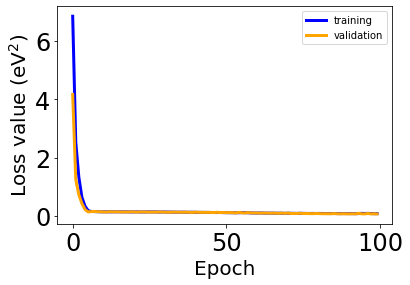

In [ ]:
plt.plot(training_loss, color='blue', label='training', lw=3)
plt.plot(validation_loss, c='orange', label='validation', lw=3)
plt.xlabel('Epoch', c='k', fontsize=20)
plt.ylabel("Loss value (eV$^2$)", c='k', fontsize=20)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.legend(loc='upper right', ncol=1, frameon=True, prop={'size':20})
plt.legend()
plt.show()

At this stage, if we are satisfied with the model training, we can call the `model.evaluate()` function on the training, validation, and test sets to measure model performance. If we wish to improve training, we would go back and change parameters in the building of the model such as running the training for more epochs or adding more layers to the model. The effect of these changes will be tracked by the learning curves.

In [ ]:
#The model.evaluate() function evaluates the model on the training, validation and testing datasets
mse_train = model.evaluate(Xtrain, Ytrain)
mse_val = model.evaluate(Xval, Yval)
mse_test = model.evaluate(Xtest, Ytest)

print(f"Averaged Squared Error For each Data Partition:\nTrain:\t\t{mse_train}\nValidation:\t{mse_val}\nTest:\t\t{mse_test}")

4/4 [==============================] - 0s 4ms/step - loss: 0.0762
Averaged Squared Error For each Data Partition:
Train:		0.08373319357633591
Validation:	0.07621278613805771
Test:		0.0762237161397934


We can save the model into an h5 format training by using the `model.save()` function. This saved model can be reloaded using the `load_model()` function.

This tool is running in a read only filesystem, so this code is just for reference.

model.save('./Models/nn_c_bg.h5')

load_model = keras.models.load_model('./Models/nn_c_bg.h5')

### Step 7. Make some predictions

We can call the `model.predict()` function to make predictions. We will use this function to make predictions on the train, validation and test sets. We expect good predictions for the training and validation sets, but the predictions on the test sets are unknown

In [ ]:
Y_pred_tr = model.predict(Xtrain)
Y_pred_val = model.predict(Xval)
Y_pred_test = model.predict(Xtest)

4/4 [==============================] - 0s 4ms/step


### Step 8. Visualize results

We are now ready to visualize the results of our training. One way to do this is to plot the model predictions compared to the ground truth data, known as a parity plot. We see that the model does a reasonable job at predicting band gaps for each of the train, validation, and test sets. Note that in a real world application, we will not know the ground truth values for the test set.



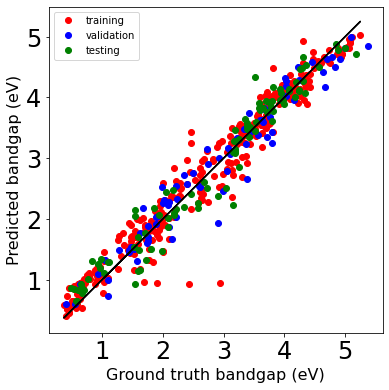

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(Ytrain, Y_pred_tr, 'ro', label="training")
plt.plot(Yval, Y_pred_val, 'bo', label="validation")
plt.plot(Ytest, Y_pred_test, 'go', label="testing")
plt.plot(Ytrain, Ytrain, 'k-')
plt.gca().set_aspect(1.0)
plt.xlabel('Ground truth bandgap (eV)', c='k', fontsize=16)
plt.ylabel("Predicted bandgap (eV)", c='k', fontsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.legend()
plt.show()